This notebook contains two parts to analyse detections performed with a policy.

1. Analyse detections based on the csv file containing person counts at all timestamps 
2. Analyse detections based on the csv file containing only the detections and their coordinates. This file does not contain all the timestamps specificallly those timestamps where no objects were detected. This requires post-processing.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from icecream import ic

1. Analyses based on all timestamps and person counts.

In [3]:
def calculate_metrics(df_ground : pd.DataFrame, df_calculated : pd.DataFrame):
    
    true_values = df_ground      
    calculated_values =df_calculated

    true_values = true_values.set_index('timestamp')
    calculated_values = calculated_values.set_index('timestamp')

    true_values = true_values.sort_index()
    calculated_values = calculated_values.sort_index()

    # Visualize data
    plt.figure(figsize=(20, 10), dpi=80)
    plt.scatter(true_values.index, true_values["count"], color="blue", label="original")
    plt.plot(calculated_values.index, calculated_values["count"], color="red", label="predicted")
    plt.legend()
    plt.show() 

    mae = mean_absolute_error(true_values, calculated_values)
    mse = mean_squared_error(true_values, calculated_values)

    return {
        "mae": mae,
        "mse": mse
    }

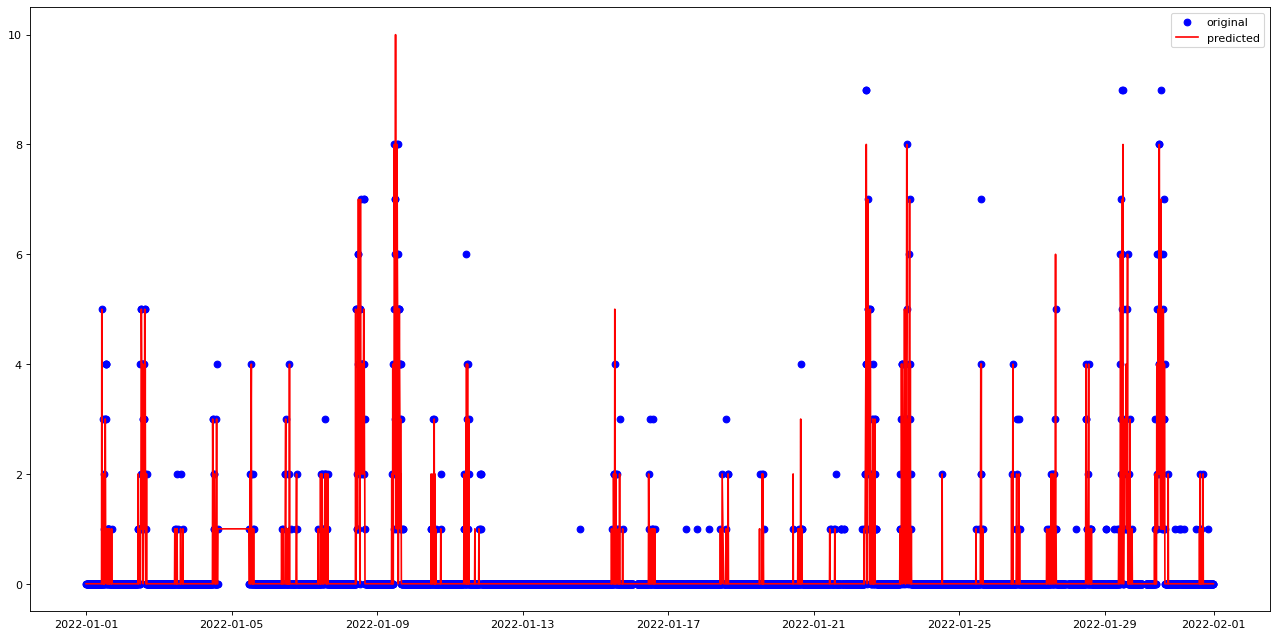

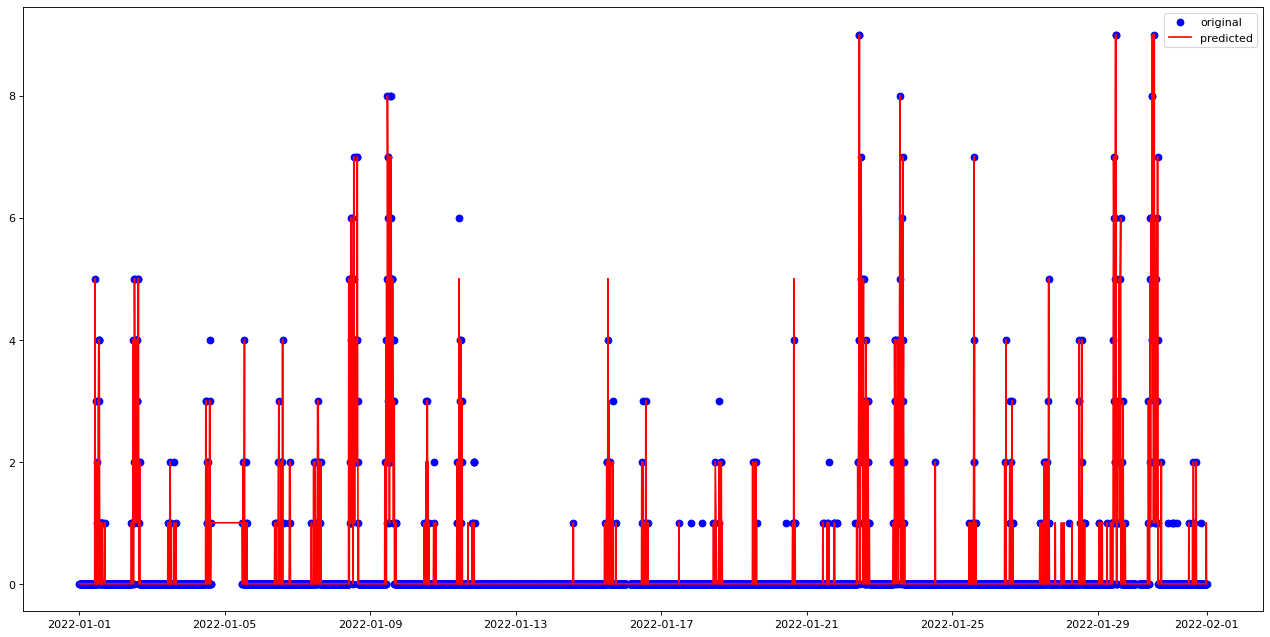

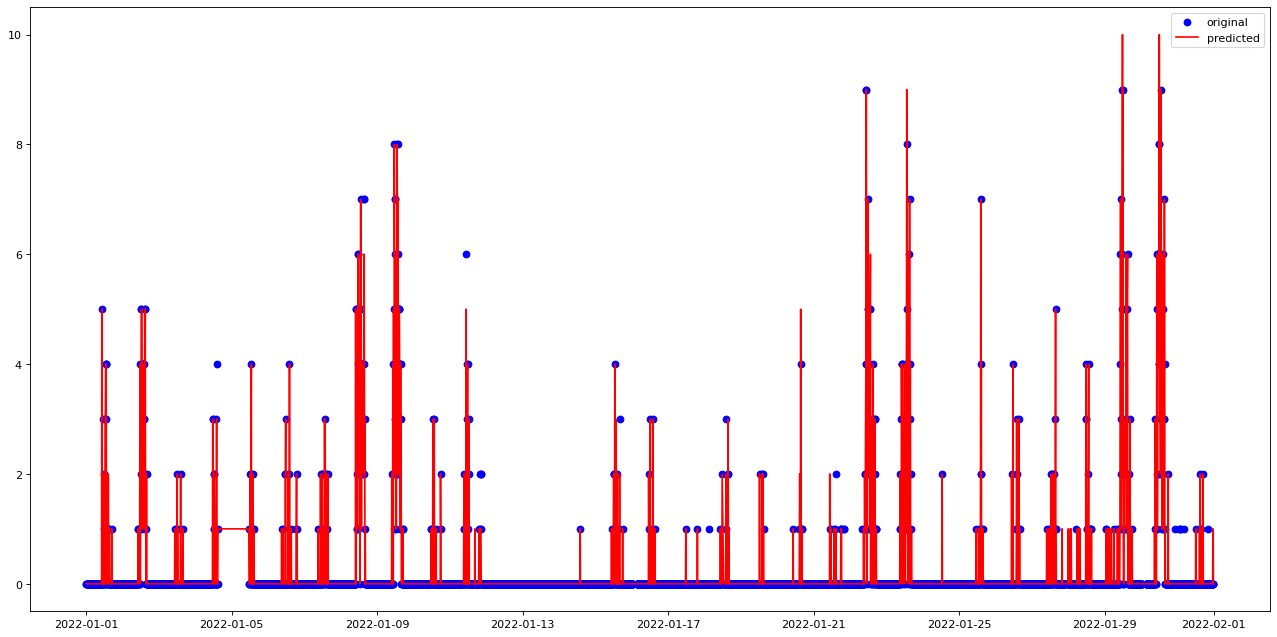

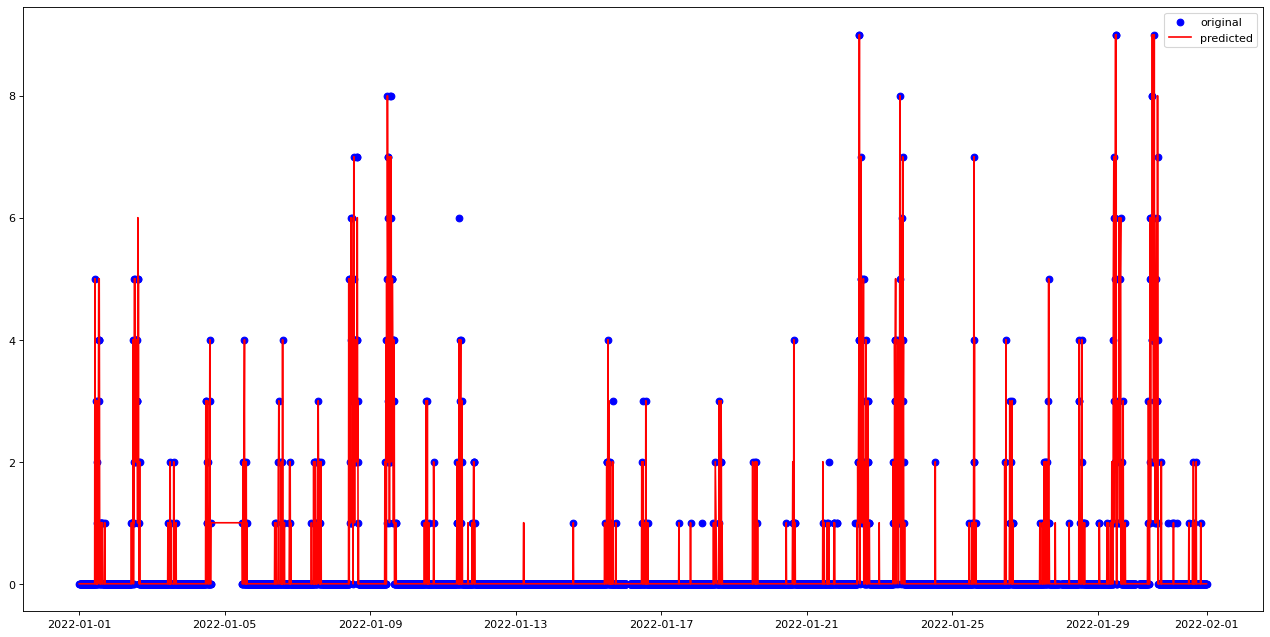

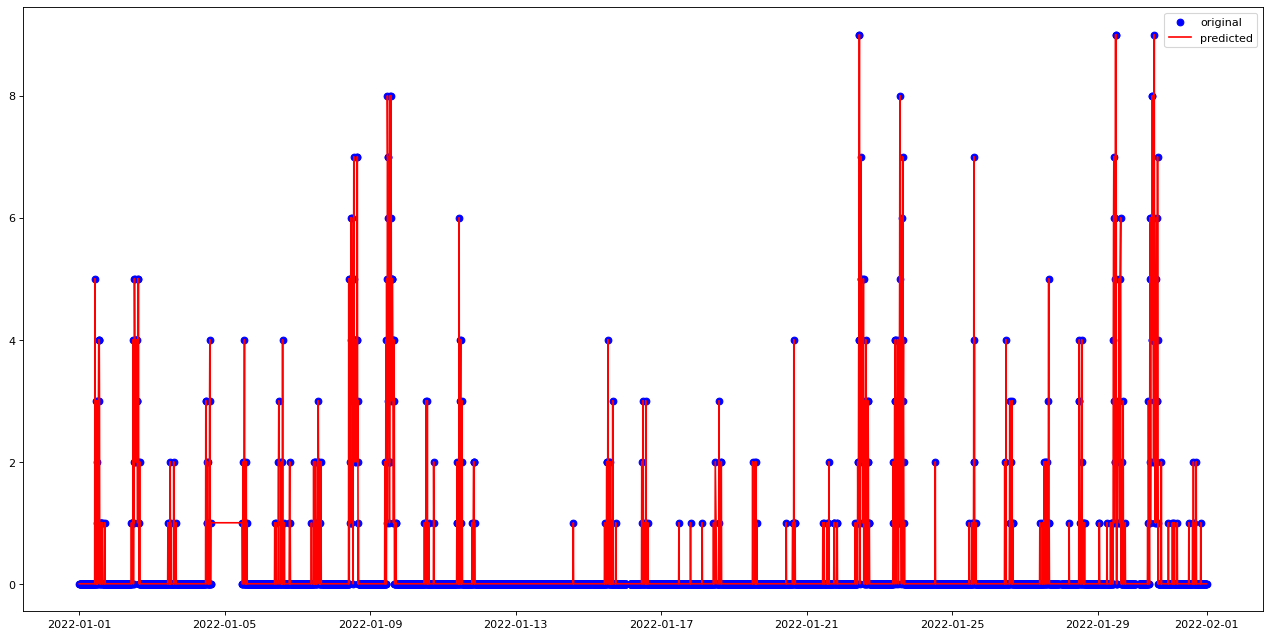

ic| mae_policy.values(): dict_values([0.07169459962756052, 0.031191806331471134, 0.030027932960893854, 0.02164804469273743, 0.0])


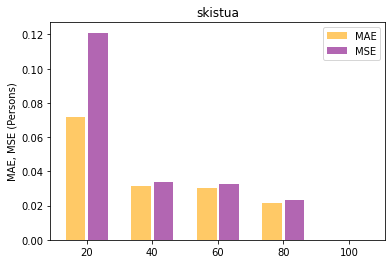

In [9]:
cams = ['skistua'] #,jervskogen_1 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

data_ground = dict()
data_policy = dict()

mae_policy = dict()
mse_policy = dict()

policy_percentages = [20, 40, 60, 80, 100]# 80, 100]#, 80] # , 40, 60,80]
exp_name_folder = 'Experiment-A/'

for cam in cams:
    data_ground[cam] = pd.read_csv('../data/datasets/local/all/'+ cam + '_all_timestamps_count' + '.csv', parse_dates=['timestamp'])
    df_cam = data_ground[cam]
    data_ground[cam] = df_cam[(df_cam['timestamp'].dt.year == 2022) & (df_cam['timestamp'].dt.month == 1)]

    data_ground[cam] = data_ground[cam][['timestamp', 'count']]

    #ic(data_ground[cam].describe())

    for policy_percentage in policy_percentages:
            data_policy[policy_percentage] = pd.read_csv('../data/datasets/local/' + exp_name_folder + cam + '_all_timestamps_count_'  + '_policy_' + str(policy_percentage) + '_tiles_64' + '.csv', parse_dates=['timestamp'])   
            data_policy[policy_percentage] = data_policy[policy_percentage][['timestamp', 'count']]

            #ic( data_policy[policy_percentage].describe())

            results = calculate_metrics(data_ground[cam], data_policy[policy_percentage])

            mae_policy[policy_percentage] = results["mae"]
            mse_policy[policy_percentage] = results["mse"]

        
# Graph
x = np.arange(len(mae_policy))
width = 0.3
ic( mae_policy.values())
#plt.clf()
plt.ylabel ('MAE, MSE (Persons)')
plt.bar(x - 0.17, mae_policy.values(), width, color = "orange", alpha = 0.6, label = 'MAE')
plt.bar(x + 0.17, mse_policy.values(), width, color = "purple", alpha = 0.6, label = 'MSE')
plt.xticks (ticks = x, labels = mae_policy.keys(), rotation = 0)
plt.title(cam)
_ = plt.legend()
plt.savefig('outputs/' + exp_name_folder + 'policy_results_' + cam + '.jpg', dpi=300, format='jpg')
plt.show()

2. Analyses based on csv file containing only detections. 
This part is not well tested. 

In [7]:
def calculate_metrics_adjust(df_ground : pd.DataFrame, df_calculated : pd.DataFrame):
    #.resample('10T', label='right').sum() 
    
    true_values = df_ground['timestamp'].sort_values().value_counts(sort=False)
    calculated_values = df_calculated['timestamp'].sort_values().value_counts(sort=False)  

    # Visualize data
    #plot = true_values.plot(rot=45, label="True values", legend=True, figsize=(20,10), title = cam_test) 
    #plot = calculated_values.plot(rot=45, label = "Calculated values", figsize=(20,10), title = cam_test) 

    # Convert to dataframe from series
    true_values = pd.DataFrame({'timestamp':true_values.index, 'count':true_values.values})
    calculated_values = pd.DataFrame({'timestamp':calculated_values.index, 'count':calculated_values.values})

    # Check missing timestamps in both arrays
    set1 = set(true_values['timestamp'])
    set2 = set(calculated_values['timestamp'])

    missing_in_set2 = list(sorted(set1 - set2))
    missing_in_set1 = list(sorted(set2 - set1))

    # Add misisng timestamps 

    # Calculated array based on policy
    ic(len(missing_in_set2))
    missing_timestamps_in_calculated = pd.DataFrame({'timestamp': missing_in_set2, 'count': [0] * len(missing_in_set2)})
    calculated_values = calculated_values.append(missing_timestamps_in_calculated, ignore_index = True).sort_values("timestamp")
    #calculated_values = calculated_values.sort_values("timestamp")
    #ic(calculated_values)

    # Ground truth array
    ic(len(missing_in_set1))
    missing_timestamps_in_true_values = pd.DataFrame({'timestamp': missing_in_set1, 'count': [0] * len(missing_in_set1)})
    true_values = true_values.append(missing_timestamps_in_true_values, ignore_index = True).sort_values("timestamp")
    #ic(true_values)

    true_values = true_values.set_index('timestamp')
    calculated_values = calculated_values.set_index('timestamp')
    
    # We resample to include the missing timestamps where both ground and calculated were equal i.e. 0 since during inference we stored only the results of timestamps in which we had detections
    true_values = true_values.resample('10T', label='right').sum() 
    calculated_values = calculated_values.resample('10T', label='right').sum() 

    true_values = true_values.sort_index()
    calculated_values = calculated_values.sort_index()

    ic(len(true_values))
    ic(len(calculated_values))

    # Visualize data
    #plt.figure(figsize=(20, 10), dpi=80)
    #plt.scatter(true_values.index, true_values["count"], color="blue", label="original")
    #plt.plot(calculated_values.index, calculated_values["count"], color="red", label="predicted")
    #plt.legend()
    #plt.show() 

    mae = mean_absolute_error(true_values, calculated_values)
    mse = mean_squared_error(true_values, calculated_values)
    #ic(mae, mse) 
    
    return mae, mse

ic| len(missing_in_set2): 60
ic| len(missing_in_set1): 19
ic| len(true_values): 4374
ic| len(calculated_values): 4374
ic| len(missing_in_set2): 22
ic| len(missing_in_set1): 89
ic| len(true_values): 4382
ic| len(calculated_values): 4382
ic| len(missing_in_set2): 14
ic| len(missing_in_set1): 102
ic| len(true_values): 4401
ic| len(calculated_values): 4401
ic| len(missing_in_set2): 13
ic| len(missing_in_set1): 64
ic| len(true_values): 4393
ic| len(calculated_values): 4393


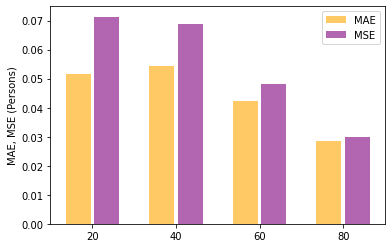

In [8]:
# Needs update
## Analyse results



cams = ['jervskogen_1'] #,jervskogen_1 'jervskogen_2', 'nilsbyen_2', 'nilsbyen_3', 'skistua')

data_ground = dict()
data_policy = dict()

mae_policy = dict()
mse_policy = dict()

policy_percentages = [20, 40, 60,80]
exp_name_folder = 'Experiment-A/'


for cam in cams:
    data_ground[cam] = pd.read_csv('../data/datasets/local/all/'+ cam + '_only_detections' + '.csv', parse_dates=['timestamp'])
    df_cam = data_ground[cam]
    df_cam = df_cam[(df_cam['timestamp'].dt.year == 2022) & (df_cam['timestamp'].dt.month == 1)]
    data_ground[cam] = df_cam[(df_cam['class']=='person') & (df_cam['conf']>0.5)]

    for policy_percentage in policy_percentages:
        data_policy[policy_percentage] = pd.read_csv('../data/datasets/local/' + exp_name_folder + cam + '_only_detections_'  + '_policy_' + str(policy_percentage) + '_tiles_64' + '.csv', parse_dates=['timestamp'])    
        df_cam = data_policy[policy_percentage]
        data_policy[policy_percentage] = df_cam[(df_cam['class']=='person') & (df_cam['conf']>0.5)]
        
        
        mae, mse  = calculate_metrics_adjust(data_ground[cam], data_policy[policy_percentage])
        mae_policy[policy_percentage] = mae
        mse_policy[policy_percentage] = mse
        
    # Graph
    x = np.arange(len(mae_policy))
    width = 0.3
    
    #plt.clf()
    plt.ylabel ('MAE, MSE (Persons)')
    plt.bar(x - 0.17, mae_policy.values(), width, color = "orange", alpha = 0.6, label = 'MAE')
    plt.bar(x + 0.17, mse_policy.values(), width, color = "purple", alpha = 0.6, label = 'MSE')
    plt.xticks (ticks = x, labels = mae_policy.keys(), rotation = 0)
    _ = plt.legend()
    #plt.savefig('outputs/' + 'pol' + cam + '.jpg', dpi=300, format='jpg')
    plt.show()
    
